# Fremont Bridge Cyclists Crossings
by Michael Kearns

![bike symbol](https://www.seattle.gov/images/Departments/SDOT/BikeProgram/cycletrack2.jpg)

# Business Understanding
Seattle is home to many cyclists who ride for both recreational or commuting purposes. Seattle has already developed extensive infrastructure that include designated walking paths and protected bike lines. Unique to Seattle geography is that North Seattle and Downtown are split by bodies of water that connect the Puget Sound to Lake Washington. This requires riders who travel from North Seattle to Downtown to cross a bridge that motor vehicles also use. I would like to build a model that can predict the number of cyclists that cross a bridge dependent on the daily weather. This project will specifically look at the Fremont Bridge, which has direct access to the South Lake Union and Downtown areas that host many major companies and business districts. The goal is this model could be used by the Seattle Department of Transportation to help improve or provide safer travel for cyclists across this bridge.

# Data Understanding
Data for this project will be collected from multiple sources. First, the city of Seattle tracks the number of cyclists that cross the Fremont bridge in both the northbound and southbound directions. To review the source in more depth, please follow this [link](https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k/about_data). Second, historical weather data from the National Center for Environmental Information (NCEI) is collected that includes daily temperature, precipitation levels, and snow levels. To review the datasource in more depth, please follow this [link](https://www.ncei.noaa.gov/access). The data will range between 2013-2024.
## Data Preparation
A key difference between the two datasets is the cyclist dataset has hourly recordings and the weather data is recorded daily.  Therefore, the cycling dataset will need to be converted to report daily numbers. All data considered will be numerical, and will have to be cleaned for possible cases of missing data or incorrectly recorded values.

In [99]:
#List all necessary imports for this notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import xgboost as xgb


#import csv file
bike_url = 'https://raw.githubusercontent.com/mkearns17/Fremont_Bridge_Cyclists_Crossings/refs/heads/main/data/Fremont_Bridge_Bicycle_Counter_20250217.csv'
bike = pd.read_csv(bike_url)

In [100]:
#Rename column names for simplicity
bike.columns = ['Date-Hr','Total','WestSidewalk','EastSidewalk']

In [101]:
#Add columns to split date and hour for each row
bike['Date'] = bike['Date-Hr'].str[:10]
bike['Hr'] = bike['Date-Hr'].str[11:]

In [102]:
#Convert Date to datetime format
bike['Date'] = pd.to_datetime(bike['Date'])

In [103]:
#Create new dataframe that sums daily crossing between 2013 and 2024
bike_filtered = bike[bike['Date']>'2012-12-31']
bike_daily = bike.groupby(bike_filtered['Date'])[['Total','WestSidewalk','EastSidewalk']].sum()

In [104]:
#import weather data
weather_url = 'https://raw.githubusercontent.com/mkearns17/Fremont_Bridge_Cyclists_Crossings/refs/heads/main/data/sea-tac_weather_2024.csv'
weather = pd.read_csv(weather_url,header=1)

In [105]:
#Filter weather data to match timeframe of bike data
weather_filtered = weather[(weather['Date']>'2012-12-31')&(weather['Date']<'2025-01-01')]

In [106]:
#simplify column names
weather_filtered.columns = ['Date','TAVG','TMAX','TMIN','PRCP','SNOW','SNWD']

In [107]:
#drop rows with missing data
weather_filtered_clean = weather_filtered.dropna(axis = 0)

In [108]:
#Set new dataframe with clean data and relevant features
weather_df = weather_filtered_clean[['TAVG','TMAX','TMIN','PRCP','SNOW','SNWD']]

#convert Date to datetime
weather_df['Date'] = pd.to_datetime(weather_filtered_clean['Date'])
weather_df.set_index('Date', inplace=True) #resets index

# Exploratory Data Analysis

In [109]:
#create folder to store images to save
#! mkdir images

mkdir: cannot create directory ‘images’: File exists


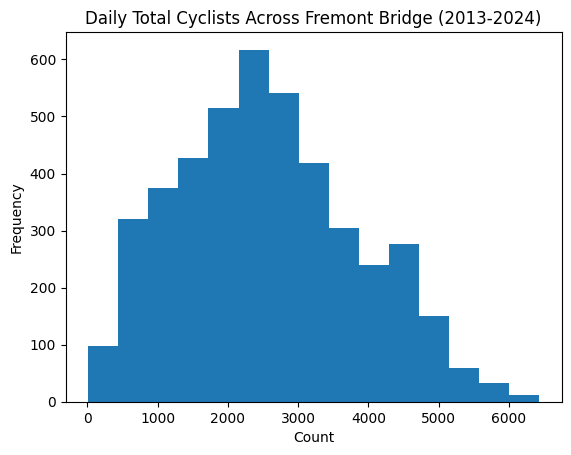

In [134]:
#plot Histogram of number of cyclists.
plt.hist(bike_daily['Total'],bins = 15)
plt.title('Daily Total Cyclists Across Fremont Bridge (2013-2024)')
plt.xlabel('Count')
plt.ylabel('Frequency');
#plt.savefig('images/bike_hist.jpg')

The histogram plot above shows that the frequency of cyclists is somewhat uniformly distributed.

In [111]:
#Create function to plot daily averages of the different features
def daily_avg_plot(df,y,title,ylabel):
    data = df
    data['day_of_year'] = data.index.dayofyear
    daily_avg = data.groupby('day_of_year')[y].mean()

    #Set Labels for plot
    date_labels = ['Jan 01', 'Feb 01', 'Mar 01', 'Apr 01', 'May 01', 'Jun 01', 'Jul 01', 'Aug 01', 'Sept 01', 'Oct 01', 'Nov 01', 'Dec 01']
    ticks = [1,32,61,92,122,153,183,214,245,275,306,336]

    plt.figure(figsize=(10, 6))

    plt.plot(daily_avg.index, daily_avg.values, marker='o', markersize = 3, linestyle='-')

    plt.xlabel('Date')
    plt.xticks(ticks = ticks, labels=date_labels, rotation=45)

    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
   #plt.savefig(f'images/{title}.jpg')
    plt.show()



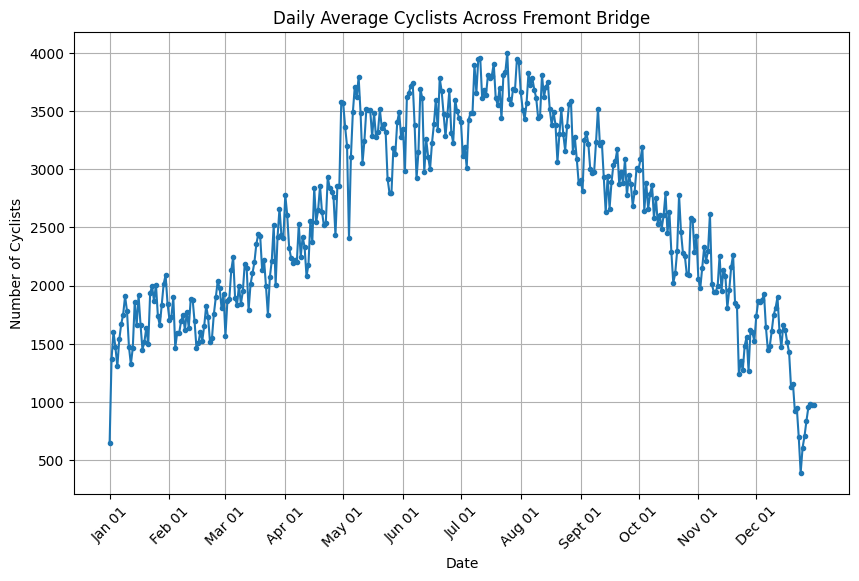

In [112]:
#Plot daily average number of cyclists across the bridge
title = 'Daily Average Cyclists Across Fremont Bridge'
ylabel = 'Number of Cyclists'
daily_avg_plot(bike_daily,'Total',title,ylabel)


This plot makes sense as it showns higher temperatures during the summer months compared to the winter months.

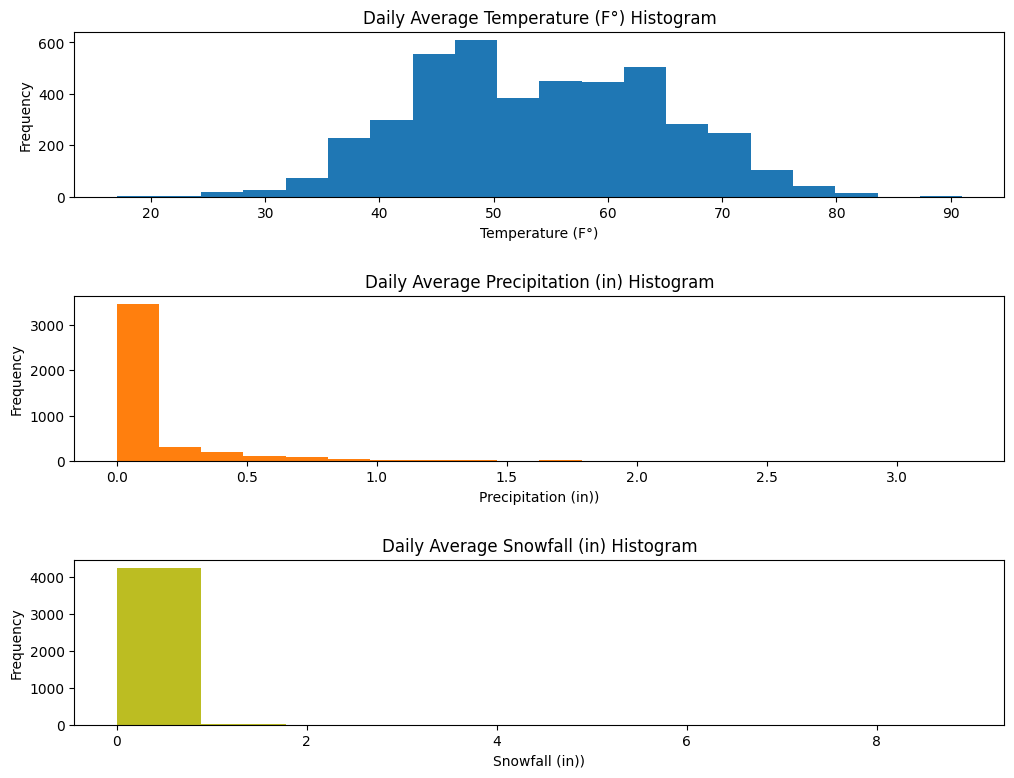

In [135]:
#plot histograms of different weather features
fig, axs = plt.subplots(3,1, figsize = (12,9))

plt.subplots_adjust(wspace=0.4, hspace=0.6)

axs[0].hist(weather_filtered_clean['TAVG'],bins = 20 , color = 'tab:blue')
axs[0].set_title('Daily Average Temperature (F°) Histogram')
axs[0].set_xlabel('Temperature (F°)')
axs[0].set_ylabel('Frequency')

axs[1].hist(weather_filtered_clean['PRCP'],bins = 20 , color = 'tab:orange')
axs[1].set_title('Daily Average Precipitation (in) Histogram')
axs[1].set_xlabel('Precipitation (in))')
axs[1].set_ylabel('Frequency')

axs[2].hist(weather_filtered_clean['SNOW'],bins = 10 , color = 'tab:olive')
axs[2].set_title('Daily Average Snowfall (in) Histogram')
axs[2].set_xlabel('Snowfall (in))')
axs[2].set_ylabel('Frequency');

#plt.savefig('images/weather_hist.jpg',bbox_inches='tight')


The average daily temperatures in Seattle are somewhat uniformily distributed. Average precipition and snowfall does not look uniformily distributed. Seattle does not receive snowfall often so that is expected. Seattle is know for the rain, but this shows that Seattle more oftenly receives low levels of precipition.

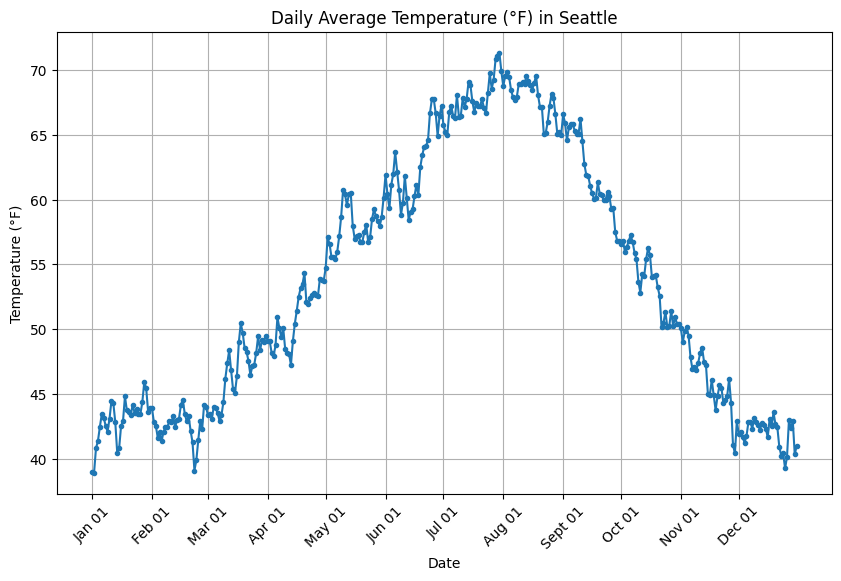

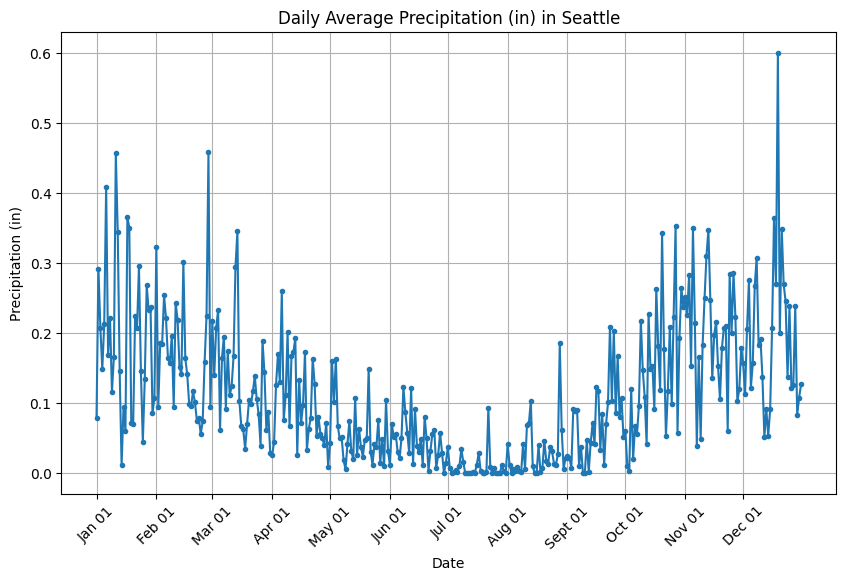

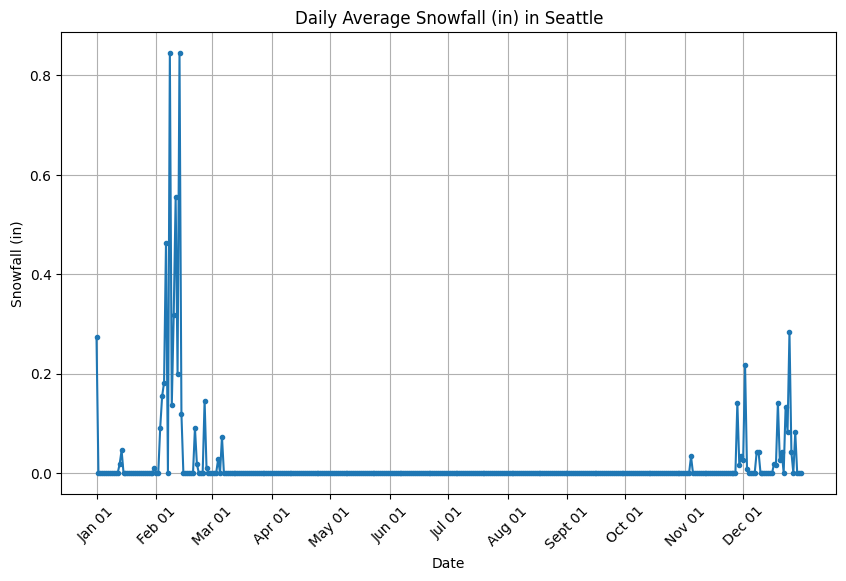

In [114]:
#Plot daily average weather features
title = ['Daily Average Temperature (°F) in Seattle',
         'Daily Average Precipitation (in) in Seattle',
         'Daily Average Snowfall (in) in Seattle',]
ylabel = ['Temperature (°F)',
          'Precipitation (in)',
          'Snowfall (in)']
y = ['TAVG','PRCP','SNOW']

for i in range(0,3):
    daily_avg_plot(weather_df,y[i],title[i],ylabel[i])

The daily plots confirm the weather patterns of more rain or snow during the winter months and higher temperatures during the summer months. This indicates a possible positive relationship between temperature and the number of cyclists, and a possible negative relationship between precipitation/snow and the number of cyclists.

In [115]:
#Combine bike and weather data together into full datset

full_df = bike_daily.join(weather_df, how = 'inner',lsuffix='_bike', rsuffix='_weather')

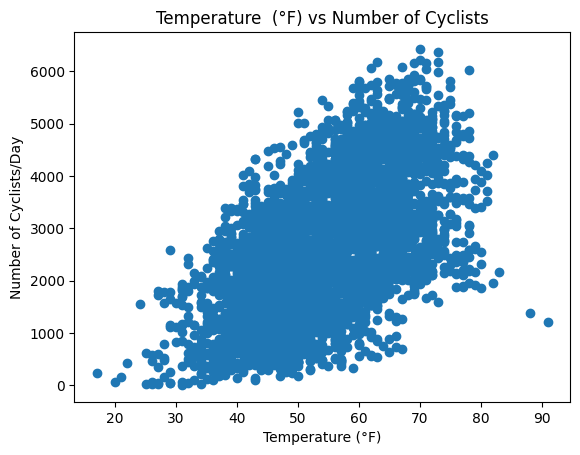

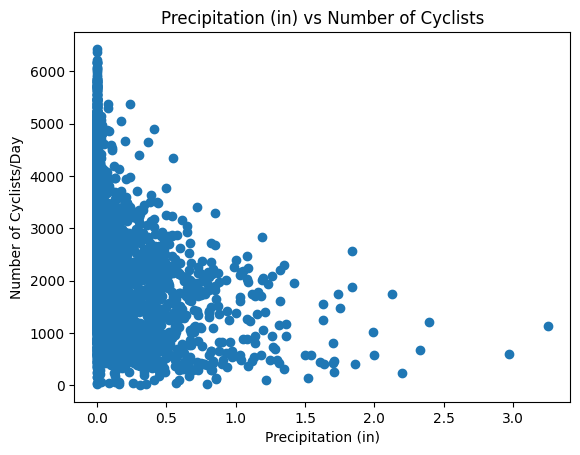

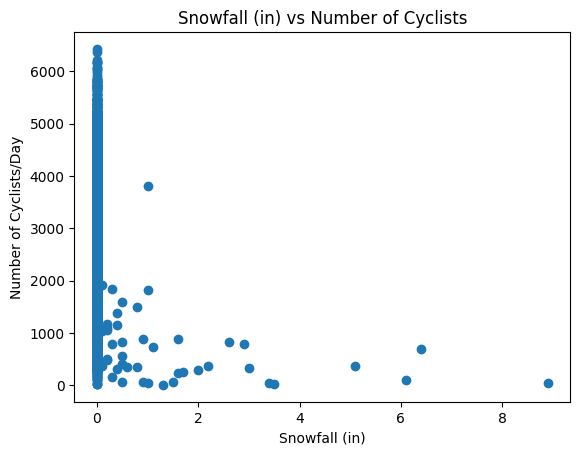

In [116]:
#Plot scatter plots of number of cyclists vs the weather features.
title = ['Temperature  (°F) vs Number of Cyclists',
         'Precipitation (in) vs Number of Cyclists',
         'Snowfall (in) vs Number of Cyclists',]
xlabel = ['Temperature (°F)',
          'Precipitation (in)',
          'Snowfall (in)']
x = ['TAVG','PRCP','SNOW']

for i in range(0,3):
    plt.scatter(full_df[x[i]],full_df['Total'])
    plt.title(title[i])
    plt.xlabel(xlabel[i])
    plt.ylabel('Number of Cyclists/Day')
    #plt.savefig(f'images/scatter_{i}.jpg',bbox_inches='tight')
    plt.show();




These plots confirm that there may be a positive linear relationship between number of cyclists and temperature. There may be an argument that there is a negative linear relationship with snowfall and preciption, but these two relationships look much less linear. This plots also show there are some datapoints that outliers and these should be removed so that they do not have too much influence on the models.

In [117]:
#Filter the dataset to remove outliers
x = ['TAVG','PRCP','SNOW']
filtered_df = full_df


# IQR Calculation
Q1 = filtered_df['TAVG'].quantile(0.25)
Q3 = filtered_df['TAVG'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
filtered_df = filtered_df[(filtered_df['TAVG'] >= lower_bound) & (filtered_df['TAVG'] <= upper_bound)]
filtered_df = filtered_df[(filtered_df['PRCP'] < 2) & (filtered_df['SNOW'] < 2)]

Should remove outliers.

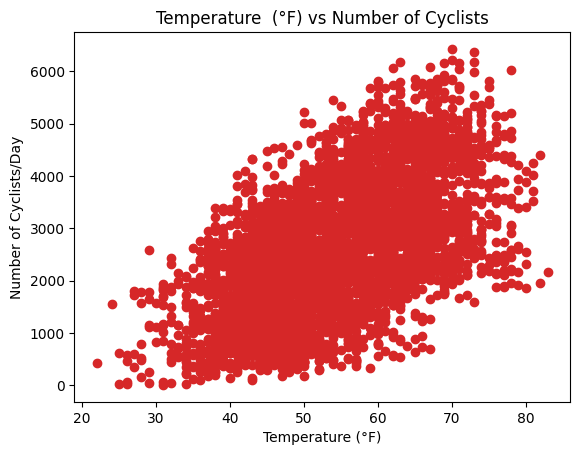

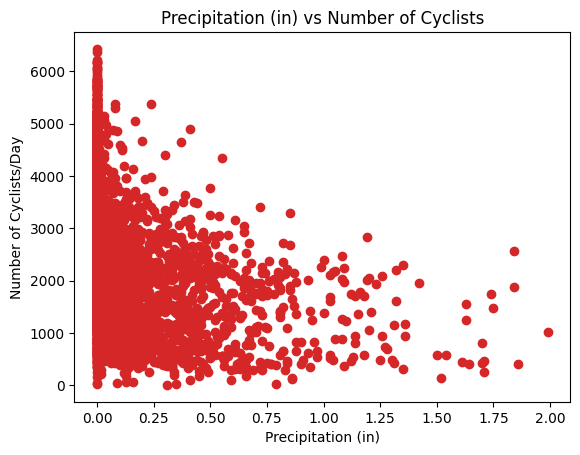

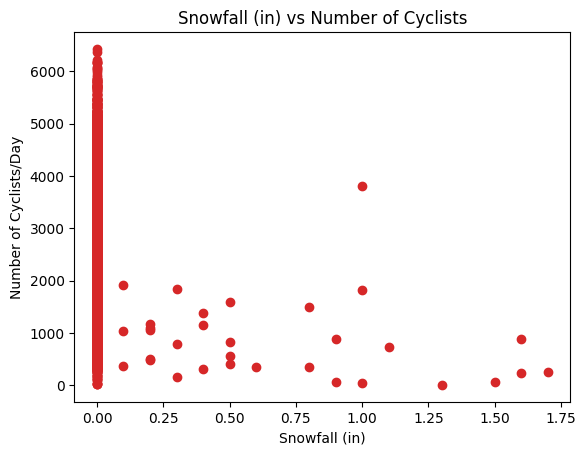

In [118]:
#replot scatter plots without outliers.
for i in range(0,3):
    plt.scatter(filtered_df[x[i]],filtered_df['Total'], color='tab:red')
    plt.title(title[i])
    plt.xlabel(xlabel[i])
    plt.ylabel('Number of Cyclists/Day')
    #plt.savefig(f'images/scatter_filtered_{i}.jpeg')
    plt.show();

Consdering if the date is a weekend or not will be intersting to look at to see if there is a significantly more or less cyclists on weekends and this could help improve the model.

In [119]:
#mark if the the day is a weekend
filtered_df['is_weekend'] = filtered_df.index.weekday >= 5
filtered_df['is_weekend'] = filtered_df['is_weekend'].astype(int)

In [120]:
#compare average total cyclists on weekends vs weekdays
weekday_check = filtered_df.groupby('is_weekend')['Total'].mean()
print('Average Daily Number of Cyclists on Weekday:',round(weekday_check[0]))
print('Average Daily Number of Cyclists on Weekend:',round(weekday_check[1]))
print('Average Daily Number of Cyclists:',round(filtered_df['Total'].mean()))

Average Daily Number of Cyclists on Weekday: 2960
Average Daily Number of Cyclists on Weekend: 1666
Average Daily Number of Cyclists: 2592


The average number of cyclists on a weekend day is significantly less than the average number of cyclists on a weekday. Perhaps this shows that the Fremont Bridge is used more for commuting towards downtown rather than for recreational cycling.

# Modeling

## Baseline Model
As a first baseline and simple model, a linear regression model will be used. To evaluate the model and future models, the RMSE value will be calculated on the training and test data. The RMSE value is acceptable to use as the model is trying to predict a continuous value. Using an error value in terms of number of cyclists will make it easier to understand the model's performance as well.

In [121]:
#select features for model
model_columns = ['TAVG','PRCP','SNOW','is_weekend'] #not using date, date is use as index to organize data

X = filtered_df[model_columns]
y = filtered_df['Total']

#Split data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.2, random_state = 42)

In [122]:
#Create pipeline to simplify process for linear regression model.
#initialize pipeline
baseline_pipe = Pipeline([('linreg', LinearRegression())])

#fit pipeline
baseline_pipe.fit(X_train,y_train)

#create function to calculate performcance of the linear regression model
def lr_model_score(model,X_train,y_train,y_test):
    #R2 score
    print('R2 Score:', model.score(X_train,y_train))

    #make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #Print model resuls
    lr_model = model.named_steps['linreg']
    print("Intercept:", lr_model.intercept_)
    print("Coefficients:", lr_model.coef_)

    #calcualte RMSE on train and test data
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    print(f"RMSE on Training Data: {rmse_train:.2f}")
    print(f"RMSE on Test Data: {rmse_test:.2f}")

lr_model_score(baseline_pipe,X_train,y_train,y_test)

R2 Score: 0.6221372955151947
Intercept: -380.59617296973374
Coefficients: [   64.67122884 -1409.59851364  -100.12769233 -1287.06361007]
RMSE on Training Data: 784.13
RMSE on Test Data: 758.18


In [123]:
baseline_cv = cross_val_score(baseline_pipe, X_train, y_train, scoring="neg_root_mean_squared_error")

# Display the average of the cross-validated RMSE
baseline_cv_rmse = -(baseline_cv.mean())
print('Cross Validation RMSE:',baseline_cv_rmse)

Cross Validation RMSE: 785.0176105125782


Features are in different units and therefore in very different scales. Scaling the data should improve results.

In [124]:
#Make Pipeline with Standard Scaler
bool_features = ['is_weekend']
continuous_features = ['TAVG','PRCP','SNOW']

scaler = StandardScaler()

preprocessor_scaler = ColumnTransformer(
    transformers=[('poly', scaler, continuous_features),  # Apply poly to continuous
                  ('bool', 'passthrough', bool_features)])         # Keep booleans unchanged

lr_pipe_scaled= Pipeline([('scaler_processor', preprocessor_scaler),
                        ('linreg', LinearRegression())])
#fit pipeline
lr_pipe_scaled.fit(X_train,y_train)

#check score
lr_model_score(lr_pipe_scaled,X_train,y_train,y_test)


R2 Score: 0.6221372955151947
Intercept: 2958.4124717591358
Coefficients: [  689.96696208  -322.25590709    -7.43378808 -1287.06361007]
RMSE on Training Data: 784.13
RMSE on Test Data: 758.18


In [125]:
lr_scaled_cv = cross_val_score(lr_pipe_scaled, X_train, y_train, scoring="neg_root_mean_squared_error")

# Display the average of the cross-validated RMSE
lr_scaled_cv_rmse = -(lr_scaled_cv.mean())
print('Cross Validation RMSE:',lr_scaled_cv_rmse)

Cross Validation RMSE: 785.0176105125784


As noted before all features do not appear to be perfectly linear. Using polynomial features should help with this.

In [126]:
#Make Pipeline with Polynomial Features
scaler = StandardScaler()
poly = PolynomialFeatures(degree=3, include_bias = False)

preprocessor = ColumnTransformer(
    transformers=[('poly-scaled', Pipeline([('scaled',scaler),
                                            ('poly',poly)]), continuous_features),  # Apply poly to continuous
                  ('bool', 'passthrough', bool_features)])         # Keep booleans unchanged

lr_pipe_scaledpoly= Pipeline([('processor', preprocessor),
                              ('linreg', LinearRegression())])
#fit pipeline
lr_pipe_scaledpoly.fit(X_train,y_train)

lr_model_score(lr_pipe_scaledpoly,X_train,y_train,y_test)


R2 Score: 0.6616091237145073
Intercept: 2889.7905132434007
Coefficients: [ 7.60911098e+02 -8.79081727e+02  4.19040486e+02 -9.17735688e+01
 -1.88684888e+02  5.27234068e+02  2.53714965e+02 -9.62822936e+01
  3.22177768e+01 -5.33497560e+01  1.54916530e+01  7.65940971e+01
  2.33020477e+01 -6.22362808e+01 -4.13612153e+00 -2.14529934e+01
  5.87754009e-01 -3.18033432e+00 -1.16071715e+00 -1.28931438e+03]
RMSE on Training Data: 742.04
RMSE on Test Data: 720.42


In [127]:
lr_scaledpoly_cv = cross_val_score(lr_pipe_scaledpoly, X_train, y_train, scoring="neg_root_mean_squared_error")

# Display the average of the cross-validated RMSE
lr_scaledpoly_cv_rmse = -(lr_scaledpoly_cv.mean())
print('Cross Validation RMSE:',lr_scaledpoly_cv_rmse)

Cross Validation RMSE: 762.3792895084564


Using the polynomial features did appear to help improve the model. However there appears to be some aspects and features not being captured in this model. Different types of models that can handle more complex and nonlinear data will be tested here.

An article posted by PubMed Central shows a study on using Machine Learning to predict Traffic Flow. This article has similar intentions to this project, and it shows that Random Forest and XGBoost models were the best performing ML models. Therefore, both types of models will be tested here to see if they have any improvements comapred to the linear regression model. To learn more about this study, follow on this [link](https://pmc.ncbi.nlm.nih.gov/articles/PMC11014399/#sec6-sensors-24-02348).

## Model Type II: Random Forest

In [128]:
#initialize model
rf = RandomForestRegressor(random_state = 42)

# Define the grid for GridsearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6]}

# Define RMSE as the scoring metric
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Set up the GridSearchCV
gridsearch = GridSearchCV(rf, param_grid, scoring=rmse_scorer, cv=5, verbose=0, n_jobs=-1, return_train_score = True)

# Fit the model
gridsearch.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10], 'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True,
             scoring=make_scorer(<lambda>, greater_is_better=False, response_method='predict'))

In [129]:
# Best parameters and score
print("Best Parameters:", gridsearch.best_params_)
print("Best RMSE:", -gridsearch.best_score_)

# Evaluate on the test set
best_model = gridsearch.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_val_pred = best_model.predict(X_val)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

rmse_train = np.sqrt(mse_train)
print("Train RMSE:", rmse_train)
rmse_test = np.sqrt(mse_test)
print("Test RMSE:", rmse_test)
rmse_val = np.sqrt(mse_val)
print("Val RMSE:", rmse_val)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 734.3548022018568
Train RMSE: 711.936648310403
Test RMSE: 713.9707234172673
Val RMSE: 690.0354690623387


The Random Forest model is performing better than the Linear Regression Model. It is better at picking the nonlinearity in the data. After using GridsearchCV, the train and test model have very close RMSE values. This shows the model is not overfitting or underfitting too much. The RMSE score on the validation set also shows that the parameters selected are performaing similary and are appropriately chosen.


Next XGBoost model will be used to see if it can performa any better than the Random Forest Model.

## Model Type III: XGBoost

In [130]:
# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

#Converting data type for features to help reduce the amount of memory required to run the model
X_train[continuous_features] = X_train[continuous_features].astype('float32')
X_train[bool_features] = X_train[bool_features].astype('int32')
y_train = y_train.astype('float32')

In [131]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],         # Number of boosting rounds
    'max_depth': [3, 5, 7],             # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage (eta)
    'subsample': [0.8, 1.0],            # Row sampling ratio
    'colsample_bytree': [0.8, 1.0]}     # Feature sampling ratio

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Metric for evaluation
    cv=5,                                   # 5-fold cross-validation
    verbose=0,                               # Output progress
    n_jobs=-1)                                # Use all CPU cores

# Fit the model with Grid Search
grid_search.fit(X_train, y_train)

# Display best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_val_pred = best_model.predict(X_val)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

rmse_train = np.sqrt(mse_train)
print("Train RMSE:", rmse_train)
rmse_test = np.sqrt(mse_test)
print("Test RMSE:", rmse_test)
rmse_val = np.sqrt(mse_val)
print("Val RMSE:", rmse_val)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best RMSE: 729.5515747070312
Train RMSE: 705.8894212268661
Test RMSE: 701.5155847528912
Val RMSE: 690.8426317427026


# Final Model

The XGBoost Model above resulted in the best performance and will be chosen for this final model. The final model will be created below with the paramters chosen from the GridSearchCV.

In [132]:
# Fit the model with Grid Search
final_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                             colsample_bytree = 0.8,
                             learning_rate= 0.1,
                             max_depth= 3,
                             n_estimators= 100,
                             subsample= 1.0)

final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [133]:
# Evaluate on the test set
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_val_pred = final_model.predict(X_val)

#calcualte RMSE on train and test data
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
rmse_val = np.sqrt(mse_val)

print(f"RMSE on Training Data: {rmse_train:.2f}")
print(f"RMSE on Test Data: {rmse_test:.2f}")
print(f"RMSE on Validation Data: {rmse_val:.2f}")

RMSE on Training Data: 705.89
RMSE on Test Data: 701.52
RMSE on Validation Data: 690.84


# Conclusions

The XGBoost model had the best performance. The RMSE on the test data shows that the error on predictions is approximately 701 cyclicsts. The validation set RMSE was similar meaning that the parameters of the model are selected well.

This model can be used by the city of Seattle to have a prediction of number of cyclists across the Fremont Bridge on a give day based on the forecasted weather. Using this information they can be informed to allow for more or less vehicular traffic, or even limit the number of times the bridge is raised to allow for continuous traffic flow.

## Limitations

A major limitation to this model is that weather is not the only factor to the number of cyclists. Holidays, major public events, off school days, races, and many other factors could impact the number of cyclists. As this model does not consider these, the performance will always be limited.

Another limitation is that weather data used for this model is daily weather recorded near the Sea-Tac International Airport weather station. This is some miles aways away and exact weather numbers could differ at the bridge. As well as the bike data collected is hourly and that hourly data could be more insightful.


## Next Steps

Next steps would be to incorparate additional features into the model and expand upon the amount of weather data provided.

Using a time series model may be worth exploring here as there is some seasonality factors to the data.